In [ ]:
from local.torch_basics import *
from local.test import *
from local.core import *
from local.layers import *
from local.data.all import *
from local.optimizer import *
from local.learner import *
from local.metrics import *
from local.callback.all import *
from local.vision.all import *

In [ ]:
path = untar_data(URLs.CAMVID)

In [ ]:
camvid = DataBlock(types=(PILImage, PILMask),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=lambda o: path/'labels'/f'{o.stem}_P{o.suffix}')

In [ ]:
dbunch = camvid.databunch(path/"images", bs=16, item_tfms=Resize((360,480)), batch_tfms=aug_transforms())

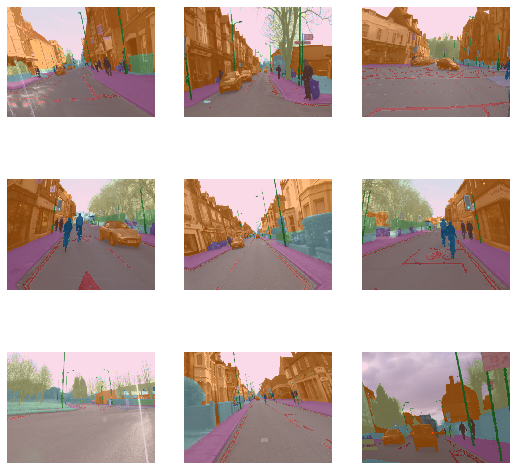

In [ ]:
dbunch.show_batch(max_n=9, vmin=1, vmax=30)

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
dbunch.vocab = codes

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    input = input.argmax(dim=1)
    target = target.squeeze(1)
    mask = target != void_code
    mask.__class__ = Tensor
    return (input[mask]==target[mask]).float().mean()

In [ ]:
opt_func = partial(Adam, lr=3e-3, wd=0.01)

In [ ]:
learn = unet_learner(dbunch, resnet34, loss_func=CrossEntropyLossFlat(axis=1), opt_func=opt_func, path=path, metrics=acc_camvid)

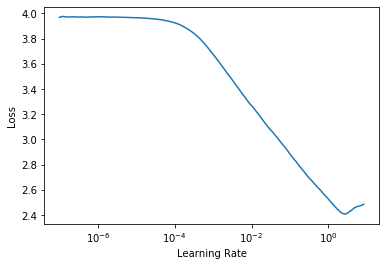

In [ ]:
learn.lr_find()

In [ ]:
lr= 3e-2#3e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,2.241798,2.383751,0.700008,00:37
1,1.218269,1.059705,0.807541,00:37
2,0.771313,0.707599,0.849559,00:37
3,0.642279,0.635115,0.856967,00:37
4,0.580600,0.565535,0.858199,00:37
5,0.514298,0.522574,0.874743,00:37
6,0.484421,0.433455,0.889242,00:37
7,0.439666,0.416293,0.894657,00:37
8,0.415688,0.381985,0.902224,00:37
9,0.403911,0.376818,0.902647,00:37


In [ ]:
learn.save('stage-1')

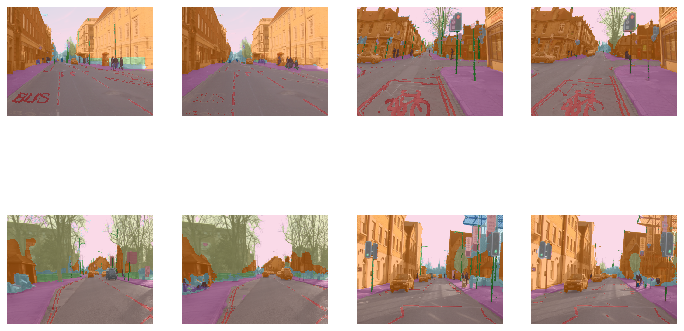

In [ ]:
learn.show_results(max_n=4, vmin=1, vmax=30)

In [ ]:
learn.load('stage-1')
learn.unfreeze()

In [ ]:
learn.opt.clear_state()

In [ ]:
lr = 1e-3
lrs = slice(lr/100,lr)

In [ ]:
learn.fit_one_cycle(12, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.395706,0.373952,0.903675,00:37
1,0.394487,0.377345,0.904052,00:37
2,0.395000,0.371336,0.904967,00:38
3,0.401875,0.370633,0.905732,00:38
4,0.385176,0.360557,0.906561,00:37
5,0.376059,0.361911,0.906642,00:38
6,0.370502,0.352127,0.908036,00:38
7,0.366369,0.354304,0.908041,00:38
8,0.365843,0.354230,0.908111,00:38
9,0.363239,0.347874,0.909707,00:38


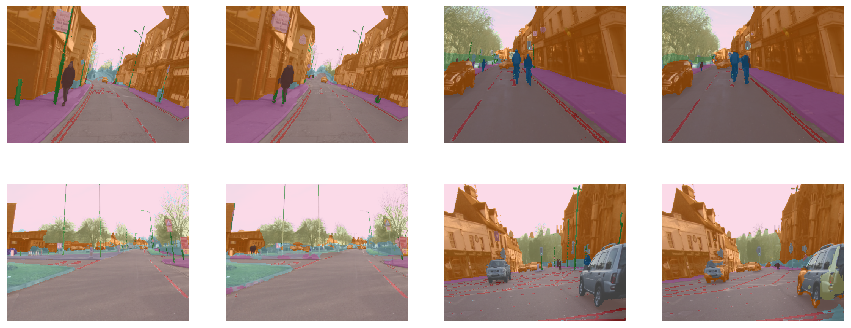

In [ ]:
learn.show_results(max_n=4, vmin=1, vmax=30, figsize=(15,6))